# TYC70 Single cell segmentation assignment pipeline

In [1]:
# I use cellpose as env
import os
import cv2
import numpy as np
from skimage.measure import regionprops
from skimage.morphology import remove_small_objects
from scipy.spatial import cKDTree
from collections import Counter
from scipy.ndimage import distance_transform_cdt
from skimage.segmentation import watershed
import matplotlib.pyplot as plt
from skimage.segmentation import relabel_sequential

## Code for frame 0 ROI 17

In [2]:
# --- Parameters ---
MN_size = 200
MN_linkage_distance = 100

# --- Paths ---
base_wl_seg = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\WhiteLight_clusters_cellpose"
base_membrane_seg = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\460nm_ImgGS"
base_nucleus_seg = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\637nm_ImgGS_test"

output_sc_cancer_seg_nucleus = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\637nm_SC_cancer_only_segm"
output_sc_immune_seg_nucleus = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\637nm_SC_immune_only_segm"
output_sc_cancer_seg_membrane = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\Whitelight_SC_clusters_cellpose"
output_sc_immune_seg_membrane = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\460nm_SC_cellpose"


os.makedirs(output_sc_cancer_seg_nucleus, exist_ok=True)
os.makedirs(output_sc_immune_seg_nucleus, exist_ok=True)
os.makedirs(output_sc_cancer_seg_membrane, exist_ok=True)
os.makedirs(output_sc_immune_seg_membrane, exist_ok=True)

# --- Loop through specified frames and ROIs ---
frames_to_process = range(0, 61)
rois_to_process = range(0, 1)

In [3]:
from skimage.measure import label

segmentation_nuclei_counts = []
segmentation_membrane_cells_counts = []
segmentation_wl_cells_counts = []

cancer_cell_with_mn = []
cancer_cell = []
immune_cell = []
mn = []
nucleus_not_mn_no_mask = []
mn_not_linked_to_nucleus = []

type_to_list = {
    1: cancer_cell_with_mn,
    2: cancer_cell,
    3: immune_cell,
    4: mn,
    5: nucleus_not_mn_no_mask,
    6: mn_not_linked_to_nucleus
}

valid_immune_cell_counts = []
valid_cancer_cell_counts = []
valid_total_cell_counts = []

for frame in frames_to_process:
    for roi in rois_to_process:
        
        roi = 17
        # Getting the naming for the files right
        roi_str = f"ROI{roi}"
        wl_fname = f"72hr_recording_WL_1ms_WhiteLight_frame{frame:05d}_{roi_str}.tif"
        membrane_fname = f"72hr_recording_50B_2000ms_frame{frame:05d}_{roi_str}.tif"
        nucleus_fname = f"72hr_recording_50R_2500ms_frame{frame:05d}_{roi_str}.tif"

        # File paths
        wl_path = os.path.join(base_wl_seg, wl_fname)
        membrane_path = os.path.join(base_membrane_seg, membrane_fname)
        nucleus_path = os.path.join(base_nucleus_seg, nucleus_fname)

        if not os.path.exists(wl_path) or not os.path.exists(membrane_path) or not os.path.exists(nucleus_path):
            print(f"Skipping {roi_str} (Frame {frame}): Files not found.")
            continue
        
        print(f"Processing {wl_fname}")

        # Loading and processing images
        wl_img_mask = cv2.imread(wl_path, -1)
        membrane_img_mask = cv2.imread(membrane_path, -1)
        nucleus_img_mask = cv2.imread(nucleus_path, -1)

        nucleus_img_mask_no_MN = remove_small_objects(nucleus_img_mask, min_size=MN_size)

        # Assuming masks are already labeled (1,2,3, ...)
        nuclei_regions = regionprops(nucleus_img_mask)
        nuclei_no_MN_regions = regionprops(nucleus_img_mask_no_MN)
        immune_cell_regions = regionprops(membrane_img_mask)
        wl_labeled = label(wl_img_mask)
        wl_cell_regions = regionprops(wl_labeled)

        # Sanity print to see if it is correct
        print("\n--- Raw mask labels found ---")
        print(f"Found {len(nuclei_regions)} unique nuclei")
        print(f"Found {len(nuclei_no_MN_regions)} unique nuclei after MN filtering")
        print(f"Found {len(immune_cell_regions)} unique T-cell membranes")
        print(f"Found {len(wl_cell_regions)} unique WL membranes")

        segmentation_nuclei_counts.append(len(nuclei_regions))
        segmentation_membrane_cells_counts.append(len(immune_cell_regions))
        segmentation_wl_cells_counts.append(len(wl_cell_regions))

        # Assigning nucleus cell type/getting IDs of the labels to link
        nucleus_to_membrane_map = {}
        nucleus_to_type = {}

        # Getting centroids of all nuclei labels for MN logic
        # make it a set so its O(1) to get the labels or check labels
        nuclei_no_MN_labels = set(n.label for n in nuclei_no_MN_regions)
        # If the nuclei is in nuclei no MN and raw it is a nucleus or cell
        nuclei_only = [region for region in nuclei_regions if region.label in nuclei_no_MN_labels]        
        nuclei_only_centroids = [region.centroid for region in nuclei_only]
        nuclei_labels = set(region.label for region in nuclei_only)

        kdtree = cKDTree(nuclei_only_centroids)
        MN_to_nucleus_map = {}
        float_comparison = 1e-6

        # For loop to decide if its a Immune cell, cancer cell, no mask nucleus or MN
        for nucleus_region in nuclei_regions:
            # If the nucleus label is in the labeled_nuclei_no_MN it is a nucleus
            # Else it is a MN (Micronuclei) do logic what you want to do with MN
            if nucleus_region.label in nuclei_no_MN_labels:
                centroid_nucleus = tuple(np.round(nucleus_region.centroid).astype(int))
                # Assign to nucleus to the correct type and mask
                if membrane_img_mask[centroid_nucleus] > 0:
                    nucleus_to_membrane_map[nucleus_region.label] = membrane_img_mask[centroid_nucleus]
                    nucleus_to_type[nucleus_region.label] = 3

                elif wl_labeled[centroid_nucleus] > 0:
                    nucleus_to_membrane_map[nucleus_region.label] = wl_labeled[centroid_nucleus] 
                    if nucleus_region.label not in nucleus_to_type:
                        nucleus_to_type[nucleus_region.label] = 2

                else:
                    nucleus_to_type[nucleus_region.label] = 5
            else:
                nucleus_to_type[nucleus_region.label] = 4
            
        # For loop to link the MN to the closest nucleus
        for nucleus_region in nuclei_regions:
            if nucleus_region.label not in nucleus_to_type:
                # This should not happen since all nuclei should be classified by now
                print(f"Error: Nucleus {nucleus_region.label} was not classified.")
                continue  # Skip if somehow not classified

            # MN logic
            if nucleus_to_type[nucleus_region.label] == 4:
                centroid_MN = tuple(np.round(nucleus_region.centroid).astype(int))
                dists, indices_nuclei_only_centroid_list = kdtree.query(centroid_MN, k=2, distance_upper_bound=MN_linkage_distance)
                
                # No nucleus within radius
                if np.isinf(dists[0]):
                    nucleus_to_type[nucleus_region.label] = 6
                    continue
                # Check if there are two cells in equal distance from the MN
                elif abs(dists[0]-dists[1]) < float_comparison:
                    nucleus_to_type[nucleus_region.label] = 6
                    continue

                # Put MN ID in a dictionary that links it to the closest nucleus's ID
                assigned_label = nuclei_only[indices_nuclei_only_centroid_list[0]].label
                MN_to_nucleus_map[nucleus_region.label] = assigned_label
                if assigned_label in nucleus_to_membrane_map:
                    nucleus_to_membrane_map[nucleus_region.label] = nucleus_to_membrane_map[assigned_label]
                if nucleus_to_type[assigned_label] == 2:
                    nucleus_to_type[assigned_label] = 1       
       
        print("\n--- Nucleus Type Assignment Summary ---")
        print("Nucleus types assigned:")
        for k, v in sorted(Counter(nucleus_to_type.values()).items()):
            label_name = {1: "Cancer (with MN)", 2: "Cancer (WL)", 3: "Immune (Membrane)", 4: "MN", 5: "Nucleus not MN with no mask", 6: "MN not linked to nucleus"}.get(k, f"Unknown ({k})")
            print(f"  {label_name}: {v} nuclei")

            if k in type_to_list:
                type_to_list[k].append(v)

        # Linking between MNs and nuclei sanity check
        nucleus_mn_count = Counter(MN_to_nucleus_map.values())
        mn_linkage_summary = Counter()

        # Loop through the nucleus_mn_count to categorize the linkage for cancer cells
        for nucleus_id, count in nucleus_mn_count.items():
            if nucleus_to_type.get(nucleus_id) == 1:  # Check if the nucleus is a cancer cell (type 1)
                mn_linkage_summary[count] += 1
            # else:
            #     print(f"type of nucleus is not 1 its: {nucleus_to_type.get(nucleus_id)}")

        # Print out the summary of how many cancer cells have 1, 2, 3... MNs linked
        print("\n--- Cancer Cells and MN Linkage Summary ---")
        for num_mns, num_cells in sorted(mn_linkage_summary.items()):
            label_name2 = f"{num_mns} MN{'s' if num_mns > 1 else ''} linked"
            print(f"  {num_cells} cancer cells have {label_name2}.")

        # -----------------------------------------------------------------------
        # Now create the voronoi to get single cell accuracy for the cancer cells in a cluster
        label_counts_cancer_only = Counter(
            nucleus_to_membrane_map[nucleus_label] 
            for nucleus_label, nucleus_type in nucleus_to_type.items() 
            if nucleus_type in [1, 2])
        
        label_counts_immune_only = Counter(
            nucleus_to_membrane_map[nucleus_label] 
            for nucleus_label, nucleus_type in nucleus_to_type.items() 
            if nucleus_type == 3)
        
        cluster_wl_labels = {label for label, count in label_counts_cancer_only.items() if count > 1}
        cluster_membrane_labels = {label for label, count in label_counts_immune_only.items() if count > 1}

        num_cancer_cells_in_clusters = sum(count for label, count in label_counts_cancer_only.items() if label in cluster_wl_labels)
        num_immune_cells_in_clusters = sum(count for label, count in label_counts_immune_only.items() if label in cluster_membrane_labels)
        num_wl_clusters = len(cluster_wl_labels)
        num_membrane_clusters = len(cluster_membrane_labels)

        num_single_cancer_cells = sum(count for label, count in label_counts_cancer_only.items() if count == 1)
        num_single_immune_cells = sum(count for label, count in label_counts_immune_only.items() if count == 1)

        single_cell_wl_labels = {label for label, count in label_counts_cancer_only.items() if count == 1}
        single_cell_membrane_labels = {label for label, count in label_counts_immune_only.items() if count == 1}

        total_cancer_cells = sum(1 for nucleus_type in nucleus_to_type.values() if nucleus_type in [1, 2])
        total_immune_cells = sum(1 for nucleus_type in nucleus_to_type.values() if nucleus_type == 3)

        # Debugging print statements to track the results
        print("\n--- WL Cluster Summary ---")
        print(f"Total Cancer cells: {total_cancer_cells}")
        print(f"Number of clustered WL masks: {num_wl_clusters}")
        print(f"Total cancer nuclei in clusters: {num_cancer_cells_in_clusters}")
        print(f"Total cancer nuclei that are single-cell (not in clusters): {num_single_cancer_cells}")
        print(f"Total single-cell WL masks: {len(single_cell_wl_labels)}")
        print(f"Single-cell WL masks: {single_cell_wl_labels}")

        print("\n--- Membrane Immune Cluster Summary ---")

        print(f"Total Immune cells: {total_immune_cells}")
        print(f"Number of clustered membrane masks (immune): {num_membrane_clusters}")
        print(f"Total immune nuclei in clusters: {num_immune_cells_in_clusters}")
        print(f"Total immune nuclei that are single-cell (not in clusters): {num_single_immune_cells}")
        print(f"Total single-cell membrane masks (immune): {len(single_cell_membrane_labels)}")
        print(f"Single-cell membrane masks (immune): {single_cell_membrane_labels}")

        # Creation of the single cell cancer cells & immune
        single_cell_wl_mask_boolean = np.isin(wl_labeled, list(single_cell_wl_labels))
        single_cell_wl_labeled_img = np.zeros_like(wl_labeled, dtype=np.int16)
        single_cell_wl_labeled_img = np.where(single_cell_wl_mask_boolean, wl_labeled, 0)

        single_cell_membrane_mask_boolean = np.isin(membrane_img_mask, list(single_cell_membrane_labels))
        single_cell_membrane_labeled_img = np.zeros_like(membrane_img_mask, dtype=np.int16)
        single_cell_membrane_labeled_img = np.where(single_cell_membrane_mask_boolean, membrane_img_mask, 0)

        # Creation of the cluster cells cancer cells & immune 
        cluster_cell_wl_mask_boolean = np.isin(wl_labeled, list(cluster_wl_labels))
        cluster_cell_wl_labeled_img = np.zeros_like(wl_labeled, dtype=np.int16)
        cluster_cell_wl_labeled_img = np.where(cluster_cell_wl_mask_boolean, wl_labeled, 0)

        cluster_cell_membrane_mask_boolean = np.isin(membrane_img_mask, list(cluster_membrane_labels))
        cluster_cell_membrane_labeled_img = np.zeros_like(membrane_img_mask, dtype=np.int16)
        cluster_cell_membrane_labeled_img = np.where(cluster_cell_membrane_mask_boolean, membrane_img_mask, 0)

        # Creation of the nucleus image seperate
        single_cell_nucleus_cancer_labeled_img = np.zeros_like(wl_labeled, dtype=np.int16)
        single_cell_nucleus_immune_labeled_img = np.zeros_like(membrane_img_mask, dtype=np.int16)

        # Filling in nuclei regions to the membrane masks
        for nucleus_region in nuclei_regions:
            coords = nucleus_region.coords

            # Check if the nucleus is a nucleus of a cancer cell (WL label) or immune cell (membrane label)
            if nucleus_to_type[nucleus_region.label] in [1, 2, 4]:
                single_cell_nucleus_cancer_labeled_img[coords[:, 0], coords[:, 1]] = nucleus_region.label
                if nucleus_to_type[nucleus_region.label] in [1, 2]:
                    if nucleus_to_membrane_map[nucleus_region.label] in single_cell_wl_labels:
                        single_cell_wl_labeled_img[coords[:, 0], coords[:, 1]] = nucleus_to_membrane_map[nucleus_region.label]
                    elif nucleus_to_membrane_map[nucleus_region.label] in cluster_wl_labels:
                        cluster_cell_wl_labeled_img[coords[:, 0], coords[:, 1]] = nucleus_to_membrane_map[nucleus_region.label]
            
            elif nucleus_to_type[nucleus_region.label] == 3:
                single_cell_nucleus_immune_labeled_img[coords[:, 0], coords[:, 1]] = nucleus_region.label
                if nucleus_to_membrane_map[nucleus_region.label] in single_cell_membrane_labels:
                    single_cell_membrane_labeled_img[coords[:, 0], coords[:, 1]] = nucleus_to_membrane_map[nucleus_region.label]
                elif nucleus_to_membrane_map[nucleus_region.label] in cluster_membrane_labels:
                    cluster_cell_membrane_labeled_img[coords[:, 0], coords[:, 1]] = nucleus_to_membrane_map[nucleus_region.label]

        # Count how many unique nuclei are in each image
        cancer_nuclei_labels = np.unique(single_cell_nucleus_cancer_labeled_img)
        immune_nuclei_labels = np.unique(single_cell_nucleus_immune_labeled_img)

        # Remove background (label 0)
        cancer_nuclei_labels = cancer_nuclei_labels[cancer_nuclei_labels != 0]
        immune_nuclei_labels = immune_nuclei_labels[immune_nuclei_labels != 0]

        print("\n--- Nucleus Assignment Summary ---")
        print(f"Number of nuclei assigned to cancer (WL-associated): {len(cancer_nuclei_labels)}")
        print(f"Number of nuclei assigned to immune (membrane-associated): {len(immune_nuclei_labels)}")

        # ---- Voronoi Segmentation ----
        # Creating the image and getting centroid coordinates for the Voronoi Segmentation
        cluster_nuclei_centroids_wl = [nucleus_region.centroid for nucleus_region in nuclei_regions
                                        if nucleus_to_type[nucleus_region.label] in [1,2] 
                                        and nucleus_region.label in nucleus_to_membrane_map 
                                        and nucleus_to_membrane_map[nucleus_region.label] in cluster_wl_labels]
        
        cluster_nuclei_centroids_membrane = [nucleus_region.centroid for nucleus_region in nuclei_regions 
                                             if nucleus_to_type[nucleus_region.label] == 3
                                             and nucleus_region.label in nucleus_to_membrane_map 
                                             and nucleus_to_membrane_map[nucleus_region.label] in cluster_membrane_labels]
            
        cluster_mask_binary_wl = cluster_cell_wl_labeled_img > 0
        cluster_mask_binary_membrane = cluster_cell_membrane_labeled_img > 0

        seed_mask_wl = np.zeros_like(cluster_cell_wl_labeled_img, dtype=np.int32)
        seed_mask_membrane = np.zeros_like(cluster_cell_membrane_labeled_img, dtype=np.int32)

        for i, centroid in enumerate(cluster_nuclei_centroids_wl, 1):
            y, x = map(int, np.round(centroid))
            if cluster_mask_binary_wl[y, x]:
                seed_mask_wl[y, x] = i
        
        for i, centroid in enumerate(cluster_nuclei_centroids_membrane, 1):
            y, x = map(int, np.round(centroid))
            if cluster_mask_binary_membrane[y, x]:
                seed_mask_membrane[y, x] = i

        distance_taxicab_wl = distance_transform_cdt(cluster_mask_binary_wl == 0, metric="taxicab")
        voronoi_labels_img_wl = watershed(distance_taxicab_wl, markers=seed_mask_wl, mask=cluster_mask_binary_wl)

        distance_taxicab_membrane = distance_transform_cdt(cluster_mask_binary_membrane == 0, metric="taxicab")
        voronoi_labels_img_membrane = watershed(distance_taxicab_membrane, markers=seed_mask_membrane, mask=cluster_mask_binary_membrane)
               
        # Print the Voronoi Nucleus Summary check for sanity
        print("\n--- Voronoi Nucleus Summary ---")
        print(f"Nuclei expected in wl clusters: {num_cancer_cells_in_clusters}")
        print(f"Nuclei expected in membrane clusters: {num_immune_cells_in_clusters}")

        print(f"Nuclei prepared for Voronoi: {len(cluster_nuclei_centroids_wl)}")
        print(f"Nuclei prepared for Voronoi: {len(cluster_nuclei_centroids_membrane)}")

        print(f"Unique Voronoi WL labels: {len(np.unique(voronoi_labels_img_wl)) - 1}")
        print(f"Unique Voronoi membrane labels: {len(np.unique(voronoi_labels_img_membrane)) - 1}")

        # Combining the Voronoi single cell with the single cell WL labeled image
        combined_wl_img = single_cell_wl_labeled_img.copy()
        combined_membrane_img = single_cell_membrane_labeled_img.copy()

        no_single_cell_label_wl = (single_cell_wl_labeled_img == 0)
        no_single_cell_label_membrane = (single_cell_membrane_labeled_img == 0)

        max_single_cell_label_wl = np.max(single_cell_wl_labeled_img)
        max_single_cell_label_membrane = np.max(single_cell_membrane_labeled_img)

        voronoi_labels_offset_img_wl = voronoi_labels_img_wl.copy()
        voronoi_labels_offset_img_membrane = voronoi_labels_img_membrane.copy()

        mask_voronoi_foreground_wl = voronoi_labels_img_wl > 0
        mask_voronoi_foreground_membrane = voronoi_labels_img_membrane > 0

        voronoi_labels_offset_img_wl[mask_voronoi_foreground_wl] += max_single_cell_label_wl
        voronoi_labels_offset_img_membrane[mask_voronoi_foreground_membrane] += max_single_cell_label_membrane

        combined_wl_img[no_single_cell_label_wl] = voronoi_labels_offset_img_wl[no_single_cell_label_wl]
        combined_membrane_img[no_single_cell_label_membrane] = voronoi_labels_offset_img_membrane[no_single_cell_label_membrane]

        combined_wl_img_relabel, _, _ = relabel_sequential(combined_wl_img)
        combined_membrane_img_relabel, _, _ = relabel_sequential(combined_membrane_img)
        single_cell_nucleus_cancer_labeled_img_relabeled, _, _ = relabel_sequential(single_cell_nucleus_cancer_labeled_img)
        single_cell_nucleus_immune_labeled_img_relabeled, _, _ = relabel_sequential(single_cell_nucleus_immune_labeled_img)

        print("\n--- Combined Relabel Summary ---")
        print(f"Max original single-cell label: {len(np.unique(single_cell_wl_labeled_img))}")
        print(f"Unique labels in relabeled combined WL image (excluding background): {len(np.unique(combined_wl_img_relabel)) -1}")
        print("WL relabel discrepancy:", len(np.unique(combined_wl_img_relabel)) - total_cancer_cells)
        print(f"Unique labels in relabeled combined memrbane image (excluding background): {len(np.unique(combined_membrane_img_relabel)) -1}")
        print(f"Unique nuclei in WL mask: {len(np.unique(single_cell_nucleus_cancer_labeled_img_relabeled)) -1}")
        print(f"Unique nuclei in membrane mask: {len(np.unique(single_cell_nucleus_immune_labeled_img_relabeled)) -1}")

        valid_immune_cell_counts.append(len(np.unique(single_cell_nucleus_immune_labeled_img_relabeled)) -1)
        valid_cancer_cell_counts.append(len(np.unique(single_cell_nucleus_cancer_labeled_img_relabeled)) -1)
        valid_total_cell_counts.append(len(np.unique(single_cell_nucleus_cancer_labeled_img_relabeled)) -1 + len(np.unique(single_cell_nucleus_immune_labeled_img_relabeled)) -1)

        # out1 = os.path.join(output_sc_cancer_seg_nucleus, nucleus_fname)
        # cv2.imwrite(out1, single_cell_nucleus_cancer_labeled_img_relabeled.astype(np.uint16))

        # out2 = os.path.join(output_sc_immune_seg_nucleus, nucleus_fname)
        # cv2.imwrite(out2, single_cell_nucleus_immune_labeled_img_relabeled.astype(np.uint16))

        # out3 = os.path.join(output_sc_cancer_seg_membrane, wl_fname)
        # cv2.imwrite(out3, combined_wl_img_relabel.astype(np.uint16))

        # out4 = os.path.join(output_sc_immune_seg_membrane, membrane_fname)
        # cv2.imwrite(out4, combined_membrane_img_relabel.astype(np.uint16))


Processing 72hr_recording_WL_1ms_WhiteLight_frame00000_ROI17.tif

--- Raw mask labels found ---
Found 1850 unique nuclei
Found 1685 unique nuclei after MN filtering
Found 1698 unique T-cell membranes
Found 2041 unique WL membranes

--- Nucleus Type Assignment Summary ---
Nucleus types assigned:
  Cancer (with MN): 55 nuclei
  Cancer (WL): 746 nuclei
  Immune (Membrane): 812 nuclei
  MN: 141 nuclei
  Nucleus not MN with no mask: 72 nuclei
  MN not linked to nucleus: 24 nuclei

--- Cancer Cells and MN Linkage Summary ---
  49 cancer cells have 1 MN linked.
  6 cancer cells have 2 MNs linked.

--- WL Cluster Summary ---
Total Cancer cells: 801
Number of clustered WL masks: 75
Total cancer nuclei in clusters: 659
Total cancer nuclei that are single-cell (not in clusters): 142
Total single-cell WL masks: 142
Single-cell WL masks: {np.int64(1025), np.int64(1538), np.int64(1539), np.int64(8), np.int64(520), np.int64(11), np.int64(524), np.int64(1035), np.int64(1037), np.int64(15), np.int64(35

KeyboardInterrupt: 

## Plot

### T-cell and Cancer Cell segmentation Counts Over Time

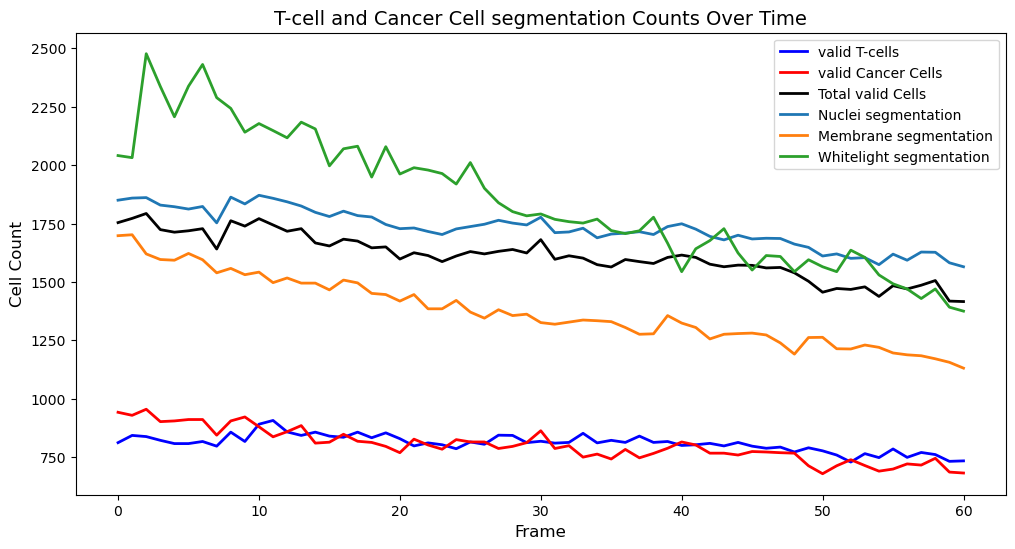

In [23]:
plt.figure(figsize=(12, 6))

plt.plot(range(len(valid_immune_cell_counts)), valid_immune_cell_counts, label="valid T-cells", color="blue", linewidth=2)
plt.plot(range(len(valid_cancer_cell_counts)), valid_cancer_cell_counts, label="valid Cancer Cells", color="red", linewidth=2)
plt.plot(range(len(valid_total_cell_counts)), valid_total_cell_counts, label="Total valid Cells", color="black", linewidth=2)

plt.plot(range(len(segmentation_nuclei_counts)), segmentation_nuclei_counts, label="Nuclei segmentation", linewidth=2)
plt.plot(range(len(segmentation_membrane_cells_counts)), segmentation_membrane_cells_counts, label="Membrane segmentation", linewidth=2)
plt.plot(range(len(segmentation_wl_cells_counts)), segmentation_wl_cells_counts, label="Whitelight segmentation", linewidth=2)

# Add labels and title
plt.xlabel("Frame", fontsize=12)
plt.ylabel("Cell Count", fontsize=12)
plt.title("T-cell and Cancer Cell segmentation Counts Over Time", fontsize=14)
plt.legend()

# Show the plot
plt.show()

### Types over time

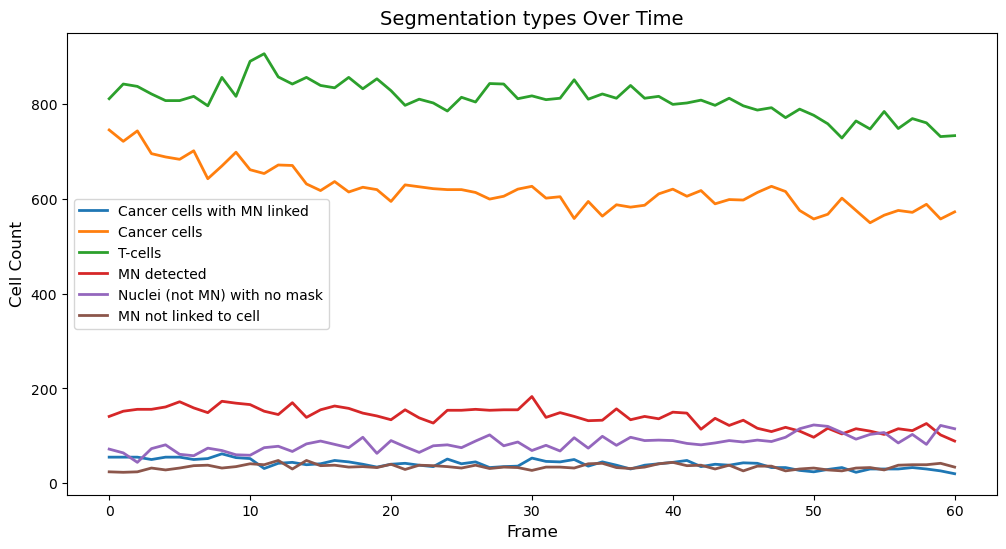

In [24]:
plt.figure(figsize=(12, 6))
# type_to_list = {
#     1: cancer_cell_with_mn,
#     2: cancer_cell,
#     3: immune_cell,
#     4: mn,
#     5: nucleus_not_mn_no_mask,
#     6: mn_not_linked_to_nucleus
# }

plt.plot(range(len(cancer_cell_with_mn)), cancer_cell_with_mn, label="Cancer cells with MN linked", linewidth=2)
plt.plot(range(len(cancer_cell)), cancer_cell, label="Cancer cells", linewidth=2)
plt.plot(range(len(immune_cell)), immune_cell, label="T-cells", linewidth=2)
plt.plot(range(len(mn)), mn, label="MN detected", linewidth=2)
plt.plot(range(len(nucleus_not_mn_no_mask)), nucleus_not_mn_no_mask, label="Nuclei (not MN) with no mask", linewidth=2)
plt.plot(range(len(mn_not_linked_to_nucleus)), mn_not_linked_to_nucleus, label="MN not linked to cell", linewidth=2)

# Add labels and title
plt.xlabel("Frame", fontsize=12)
plt.ylabel("Cell Count", fontsize=12)
plt.title("Segmentation types Over Time", fontsize=14)
plt.legend()

# Show the plot
plt.show()

In [26]:
print(cancer_cell[-1]+cancer_cell_with_mn[-1]+mn[-1])
print(cancer_cell[-1]+cancer_cell_with_mn[-1])
print(valid_cancer_cell_counts[-1])
print(valid_immune_cell_counts[-1])

682
593
682
734
